In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from glob import glob
import cv2
import torch
from PIL import Image
import tqdm

from rsl_depth_completion.diffusion.inference_utils import sample
from rsl_depth_completion.diffusion.configs import DiffusionConfig
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision as tv
from rsl_depth_completion.diffusion.training_utils import q_sample
from rsl_depth_completion.diffusion.utils import extract
from rsl_depth_completion.diffusion.utils import set_seed
from torchvision.utils import save_image
from rsl_depth_completion.diffusion.schedulers import (cosine_beta_schedule,
linear_beta_schedule,
quadratic_beta_schedule,
sigmoid_beta_schedule)
import torch.nn.functional as F
from torch.optim import Adam
import gc

from pathlib import Path
import shutil
import numpy as np
import requests
import torch
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
from minimagen.training import _Rescale, _fetch_single_image

%matplotlib inline
# %autoreload 2

# config

In [2]:
input_channels = 1
timesteps = 200
# timesteps = 30

seed = 100
set_seed(seed)

run_name='test'
results_folder = Path("./imagen_results") / run_name
shutil.rmtree(results_folder, ignore_errors=True)
results_folder.mkdir(parents=True,exist_ok = True)

input_img_size = (352, 1216)
input_channels = 1
batch_size = 2

# device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device='cpu'


# model

In [3]:
from rsl_depth_completion.conditional_diffusion.utils import get_model_params

from kbnet import data_utils
import yaml



In [4]:
import os
from datetime import datetime

import torch.utils.data
from torch import optim
from minimagen.training import (
    ConceptualCaptions,
    get_minimagen_dl_opts,
    create_directory,
)



In [5]:
import argparse
import torch
import json
args = argparse.Namespace(**{
    "PARAMETERS": "./imagen_parameters",
    "BATCH_SIZE": 1,
    "NUM_WORKERS": 0,
    "EPOCHS": 5,
    "OPTIM_LR": 0.001,
    "ACCUM_ITER": 1,
    "CHCKPT_NUM": 500,
})

In [6]:

# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
exp_name = 'overfit_img_img_kitti'
dir_path = f"./training_{exp_name}"
training_dir = create_directory(dir_path)

In [7]:
# from datasets import load_dataset
# from minimagen.training import MinimagenDataset

# dset = load_dataset("conceptual_captions")
# train_val_num = args.BATCH_SIZE*3
# val_num = args.BATCH_SIZE+1
# vi = dset["validation"]["image_url"][:val_num]
# vc = dset["validation"]["caption"][:val_num]
# ti = dset["train"]["image_url"][:train_val_num]
# tc = dset["train"]["caption"][:train_val_num]
# new_dset = {
#     "train": {
#         "image_url": ti,
#         "caption": tc,
#     },
#     "num_rows": train_val_num,
#     "validation": {
#         "image_url": vi,
#         "caption": vc,
#     },
#     "num_rows": val_num,
# }
# print(len(new_dset["train"]["image_url"]))

In [8]:

extractor_model_ref = "openai/clip-vit-base-patch32"
extractor_model = CLIPModel.from_pretrained(extractor_model_ref)
extractor_processor = CLIPProcessor.from_pretrained(extractor_model_ref)

In [9]:
ds_config_str = open("/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/configs/data/kitti_custom.yaml").read()
ds_config_str=ds_config_str.replace("${data_dir}", "/media/master/wext/cv_data/kitti-full")
ds_config = argparse.Namespace(**yaml.safe_load(ds_config_str)['ds_config'])
ds_config.use_pose = "photo" in ds_config.train_mode
ds_config.result = ds_config.result_dir
ds_config.use_rgb = ("rgb" in ds_config.input) or ds_config.use_pose
ds_config.use_d = "d" in ds_config.input
ds_config.use_g = "g" in ds_config.input
val_image_paths = data_utils.read_paths(ds_config.val_image_path)
val_sparse_depth_paths = data_utils.read_paths(
    ds_config.val_sparse_depth_path
)
val_intrinsics_paths = data_utils.read_paths(
    ds_config.val_intrinsics_path
)
val_ground_truth_paths = data_utils.read_paths(
    ds_config.val_ground_truth_path
)

In [10]:
from rsl_depth_completion.data.kitti.kitti_dataset import CustomKittiDCDataset

class MinimagenDatasetCustom(CustomKittiDCDataset):
    def __init__(
        self,
        include_cond_image=False,
        sdm_transform=None,
        *args, **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.include_cond_image = include_cond_image
        self.default_transform = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
        self.sdm_transform = sdm_transform or self.default_transform
        self.max_depth = 80
        d = argparse.Namespace(
            BATCH_SIZE=2,
            MAX_NUM_WORDS=32,
            IMG_SIDE_LEN=128,
            EPOCHS=2,
            T5_NAME='t5_small',
            TRAIN_VALID_FRAC=0.5,
            TIMESTEPS=25,  # Do not make less than 20
            OPTIM_LR=0.0001,
            VALID_NUM=None
        )
        self.train_dataset, valid_dataset = ConceptualCaptions(d, smalldata=True)


    def __getitem__(self, idx):
        items = super().__getitem__(idx)
        img = items['d']
        img /= self.max_depth
        img = self.train_dataset[idx]
        while img is None:
            img = self.train_dataset[idx]
            idx+=1
        img = img['image'][0].unsqueeze(0)
        cond_image = items['img']

        pixel_values = extractor_processor(
            images=torch.stack(
                [
                    torch.from_numpy(np.array(cond_image)),
                    torch.from_numpy(np.array(cond_image)),
                ]
            ),
            return_tensors="pt",
        ).pixel_values
        embedding = extractor_model.get_image_features(pixel_values=pixel_values)
        embedding = embedding.unsqueeze(1).to(device)
        encoding = embedding
        mask = torch.ones(embedding.shape[0], 1).bool().to(device)

        mask=mask[0]
        encoding=encoding[0]

        sample = {"image": img.detach(), "encoding": encoding.detach(), "mask": mask.detach()}
        if self.include_cond_image:
            sample["cond_image"] = cond_image.detach()
        return sample
    
ds = MinimagenDatasetCustom(
    ds_config=ds_config,
                image_paths=val_image_paths,
                sparse_depth_paths=val_sparse_depth_paths,
                intrinsics_paths=val_intrinsics_paths,
                ground_truth_paths=val_ground_truth_paths,
                include_cond_image=True,
            )
x=ds[0]
x['image'].shape, x['encoding'].shape, x['mask'].shape

2023-04-21:18:00:59,679 D WARNING  [builder.py:461] No config specified, defaulting to: conceptual_captions/unlabeled
2023-04-21:18:00:59,696 D WARNING  [builder.py:817] Found cached dataset conceptual_captions (/media/master/text/cv_data/hf_home/datasets/conceptual_captions/unlabeled/1.0.0/05266784888422e36944016874c44639bccb39069c2227435168ad8b02d600d8)


  0%|          | 0/2 [00:00<?, ?it/s]

/home/master/.conda/envs/ssdc/lib/python3.10/site-packages/transformers-4.28.1-py3.10.egg/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Some weights of the model checkpoint at t5-small were not used when initializing T5EncoderModel: ['decoder.block.4.layer.0.SelfAttention.k.weight', 'decoder.block.0.layer.0.SelfAttention.o.weight',

(torch.Size([1, 128, 128]), torch.Size([1, 512]), torch.Size([1]))

In [15]:
from minimagen.training import MinimagenCollator


ds_subset = torch.utils.data.Subset(ds, range(0, 6))
train_dataset, valid_dataset = torch.utils.data.Subset(ds, range(0, 1)), torch.utils.data.Subset(ds, range(1, 6))
# ds_subset = torch.utils.data.Subset(ds, range(0, len(ds)))
# train_size = int(0.8 * len(ds_subset))
# test_size = len(ds_subset) - train_size
# # Split into train/valid
# train_dataset, valid_dataset = torch.utils.data.random_split(
#     ds_subset,
#     # [train_size, test_size]
#     [1, 5],
#     # [2, 4]
#     # dataset_train_valid, [train_num, val_num]
# )

dl_opts = {
    "batch_size": args.BATCH_SIZE,
    "num_workers": args.NUM_WORKERS,
    "drop_last": True,
    "collate_fn": MinimagenCollator(device),
}
train_dataloader = torch.utils.data.DataLoader(train_dataset, **dl_opts, shuffle=False)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, **dl_opts, shuffle=True)


In [16]:
len(train_dataloader), len(valid_dataloader)

(1, 5)

In [17]:
x_train=next(iter(train_dataloader))
x_val=next(iter(valid_dataloader))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 x_train=next(iter(train_dataloader))                                                         │
│   2 x_val=next(iter(valid_dataloader))                                                           │
│   3                                                                                              │
│                                                                                                  │
│ /home/master/.conda/envs/ssdc/lib/python3.10/site-packages/torch/utils/data/dataloader.py:634 in │
│ __next__                                                                                         │
│                                                                                                  │
│    631 │   │   │   if self._sampler_iter is None:                                                │
│    632 │   │   │   │   # TODO(https://github.com/pytorch/pytorch/issues/76750)                   │
│    633 │   │   │   │   self._reset()  # type: ignore[call-arg]                                   │
│ ❱  634 │   │   │   data = self._next_data()                                                      │
│    635 │   │   │   self._num_yielded += 1                                                        │
│    636 │   │   │   if self._dataset_kind == _DatasetKind.Iterable and \                          │
│    637 │   │   │   │   │   self._IterableDataset_len_called is not None and \                    │
│                                                                                                  │
│ /home/master/.conda/envs/ssdc/lib/python3.10/site-packages/torch/utils/data/dataloader.py:678 in │
│ _next_data                                                                                       │
│                                                                                                  │
│    675 │                                                                                         │
│    676 │   def _next_data(self):                                                                 │
│    677 │   │   index = self._next_index()  # may raise StopIteration                             │
│ ❱  678 │   │   data = self._dataset_fetcher.fetch(index)  # may raise StopIteration              │
│    679 │   │   if self._pin_memory:                                                              │
│    680 │   │   │   data = _utils.pin_memory.pin_memory(data, self._pin_memory_device)            │
│    681 │   │   return data                                                                       │
│                                                                                                  │
│ /home/master/.conda/envs/ssdc/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py:54   │
│ in fetch                                                                                         │
│                                                                                                  │
│   51 │   │   │   │   data = [self.dataset[idx] for idx in possibly_batched_index]                │
│   52 │   │   else:                                                                               │
│   53 │   │   │   data = self.dataset[possibly_batched_index]                                     │
│ ❱ 54 │   │   return self.collate_fn(data)                                                        │
│   55                                                                                             │
│                                                                                                  │
│ /media/master/wext/msc_studies/second_semester/research_project/related_work/MinImagen/minimagen │
│ /training.py:74 in __call__                                

In [25]:
import gc; gc.collect()
torch.cuda.empty_cache()

# from minimagen.Imagen import Imagen
# from minimagen.Unet import Unet
from rsl_depth_completion.conditional_diffusion.imagen import Imagen
from rsl_depth_completion.conditional_diffusion.Unet import Unet
params = json.load(
    open(
        "/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/full_params.json"
    )
)

# Create Unets accoridng to unets_params
unets = [Unet(**params['unet_base']).to(device), Unet(**params['unet_super_resolution']).to(device)]

# Create Imagen from UNets with specified imagen parameters
imagen = Imagen(unets=unets, **params['imagen_parameters']).to(device)

args.OPTIM_LR = 0.0005
optimizer = optim.Adam(imagen.parameters(), lr=args.OPTIM_LR)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│    1 import gc; gc.collect()                                                                     │
│ ❱  2 torch.cuda.empty_cache()                                                                    │
│    3                                                                                             │
│    4 # from minimagen.Imagen import Imagen                                                       │
│    5 # from minimagen.Unet import Unet                                                           │
│                                                                                                  │
│ /home/master/.conda/envs/ssdc/lib/python3.10/site-packages/torch/cuda/memory.py:133 in           │
│ empty_cache                                                                                      │
│                                                                                                  │
│   130 │   │   more details about GPU memory management.                                          │
│   131 │   """                                                                                    │
│   132 │   if is_initialized():                                                                   │
│ ❱ 133 │   │   torch._C._cuda_emptyCache()                                                        │
│   134                                                                                            │
│   135                                                                                            │
│   136 def memory_stats(device: Union[Device, int] = None) -> Dict[str, Any]:                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be 
incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

In [24]:
!export CUDA_LAUNCH_BLOCKING=1

In [16]:
weights_dir = './training_overfit_img_img_kitti/state_dicts'
load_weights = True
load_weights = False
if load_weights:
    imagen.unets[0].load_state_dict(torch.load(f'{weights_dir}/unet_base', map_location=device))
    imagen.unets[1].load_state_dict(torch.load(f'{weights_dir}/unet_super', map_location=device))

In [17]:
train_unet_losses={"base": [], "super": []}
val_unet_losses={"base": [], "super": []}

In [18]:
from rsl_depth_completion.conditional_diffusion.train import MinimagenTrain
args.EPOCHS=200
save_train_samples_dir = '/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/training_overfit_img_img_kitti/samples_during_training_coco/'
# !rm -rf save_train_samples_dir
os.makedirs(save_train_samples_dir, exist_ok=True)

train_unet_losses_, val_unet_losses_=MinimagenTrain(
    exp_name,
    args,
    unets,
    imagen,
    train_dataloader,
    valid_dataloader,
    training_dir,
    optimizer,
    save_train_samples_dir=save_train_samples_dir,
    save_input=True,
    # start_epoch=args.EPOCHS*1,
)


### Epoch 1 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

Running Train Losses at batch 0: [1.17593, 1.07831]


sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (1.17593, 1.07831)
### Epoch 2 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (1.10039, 1.04232)
### Epoch 3 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (1.06181, 1.03035)
### Epoch 4 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (1.08227, 1.02072)
### Epoch 5 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.96714, 1.00556)
### Epoch 6 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.88796, 0.99146)
### Epoch 7 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.89497, 0.9759)
### Epoch 8 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.87353, 1.00542)
### Epoch 9 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.77724, 0.95579)
### Epoch 10 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.72618, 0.96039)
### Epoch 11 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

Running Train Losses at batch 0: [0.72862, 1.00144]


sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.72862, 1.00144)
### Epoch 12 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.72369, 0.96237)
### Epoch 13 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.71978, 0.98732)
### Epoch 14 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.66873, 0.98465)
### Epoch 15 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.60705, 0.97073)
### Epoch 16 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.59948, 0.93914)
### Epoch 17 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.56821, 0.9624)
### Epoch 18 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.63561, 0.91819)
### Epoch 19 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.88999, 0.90046)
### Epoch 20 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.8208, 0.91006)
### Epoch 21 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

Running Train Losses at batch 0: [0.60845, 0.94106]


sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.60845, 0.94106)
### Epoch 22 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.64693, 0.9303)
### Epoch 23 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.68698, 0.90583)
### Epoch 24 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.45901, 0.92079)
### Epoch 25 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.43154, 0.90311)
### Epoch 26 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.42591, 0.88377)
### Epoch 27 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (1.05009, 0.89307)
### Epoch 28 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.70879, 0.8767)
### Epoch 29 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.3941, 0.86085)
### Epoch 30 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.42058, 0.84689)
### Epoch 31 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

Running Train Losses at batch 0: [0.43387, 0.87106]


sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.43387, 0.87106)
### Epoch 32 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.36074, 0.82967)
### Epoch 33 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.36433, 0.88579)
### Epoch 34 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.70002, 0.82377)
### Epoch 35 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.33575, 0.85984)
### Epoch 36 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.3409, 0.83112)
### Epoch 37 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.33739, 0.8392)
### Epoch 38 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.6671, 0.81428)
### Epoch 39 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.31384, 0.81056)
### Epoch 40 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.30924, 0.79602)
### Epoch 41 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

Running Train Losses at batch 0: [0.27448, 0.81321]


sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.27448, 0.81321)
### Epoch 42 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.28695, 0.80347)
### Epoch 43 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.26614, 0.79096)
### Epoch 44 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.26536, 0.78603)
### Epoch 45 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.27369, 0.78078)
### Epoch 46 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.24267, 0.75054)
### Epoch 47 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.23763, 0.73822)
### Epoch 48 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.42586, 0.73781)
### Epoch 49 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.28986, 0.85602)
### Epoch 50 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.24206, 0.82089)
### Epoch 51 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

Running Train Losses at batch 0: [0.21826, 0.74449]


sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.21826, 0.74449)
### Epoch 52 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.20398, 0.73405)
### Epoch 53 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.19278, 0.73346)
### Epoch 54 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.92951, 0.7082)
### Epoch 55 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.17948, 0.71885)
### Epoch 56 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.18447, 0.87961)
### Epoch 57 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.7414, 0.6804)
### Epoch 58 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.17536, 1.00225)
### Epoch 59 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.16641, 0.69289)
### Epoch 60 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.16963, 0.69186)
### Epoch 61 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

Running Train Losses at batch 0: [0.35038, 0.68517]


sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.35038, 0.68517)
### Epoch 62 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.18774, 0.74785)
### Epoch 63 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.15616, 0.69814)
### Epoch 64 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.19057, 0.65803)
### Epoch 65 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.19123, 0.65275)
### Epoch 66 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.14344, 0.64766)
### Epoch 67 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.34234, 0.65988)
### Epoch 68 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.1771, 0.63629)
### Epoch 69 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.23738, 0.63253)
### Epoch 70 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.16002, 0.60166)
### Epoch 71 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

Running Train Losses at batch 0: [0.19236, 0.92171]


sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.19236, 0.92171)
### Epoch 72 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.44742, 0.62173)
### Epoch 73 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.13529, 0.6082)
### Epoch 74 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.1434, 1.10395)
### Epoch 75 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.14198, 0.64481)
### Epoch 76 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.62322, 0.68716)
### Epoch 77 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.13551, 0.60519)
### Epoch 78 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.13061, 0.60186)
### Epoch 79 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.14605, 0.64319)
### Epoch 80 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.13476, 0.56027)
### Epoch 81 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

Running Train Losses at batch 0: [0.12587, 0.56848]


sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.12587, 0.56848)
### Epoch 82 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.51485, 0.56988)
### Epoch 83 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.12574, 0.58807)
### Epoch 84 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.11324, 0.69087)
### Epoch 85 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.20219, 0.55997)
### Epoch 86 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.11877, 0.61965)
### Epoch 87 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.12119, 0.55166)
### Epoch 88 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.10889, 0.55979)
### Epoch 89 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.12147, 0.66949)
### Epoch 90 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.12671, 0.58161)
### Epoch 91 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

Running Train Losses at batch 0: [0.35527, 0.67766]


sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.35527, 0.67766)
### Epoch 92 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.21101, 0.60009)
### Epoch 93 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.45377, 0.52537)
### Epoch 94 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.1052, 0.62934)
### Epoch 95 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.23008, 0.51301)
### Epoch 96 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.24738, 0.50865)
### Epoch 97 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.26162, 0.52668)
### Epoch 98 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.19566, 0.51972)
### Epoch 99 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.12711, 0.77353)
### Epoch 100 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.97328, 0.50058)
### Epoch 101 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

Running Train Losses at batch 0: [0.27562, 0.48827]


sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.27562, 0.48827)
### Epoch 102 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.23348, 0.49571)
### Epoch 103 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.10415, 0.47518)
### Epoch 104 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.72093, 0.53462)
### Epoch 105 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.11522, 0.46938)
### Epoch 106 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.11163, 1.12794)
### Epoch 107 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.10463, 0.46265)
### Epoch 108 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.10663, 0.80133)
### Epoch 109 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.11011, 0.45757)
### Epoch 110 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.11418, 0.46775)
### Epoch 111 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

Running Train Losses at batch 0: [0.10865, 0.4704]


sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.10865, 0.4704)
### Epoch 112 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.11022, 0.48546)
### Epoch 113 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.09001, 0.59534)
### Epoch 114 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.44419, 0.45389)
### Epoch 115 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.13462, 0.43393)
### Epoch 116 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.29938, 0.58076)
### Epoch 117 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.0949, 0.45755)
### Epoch 118 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.11081, 0.47281)
### Epoch 119 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.08937, 0.47887)
### Epoch 120 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.0907, 0.44003)
### Epoch 121 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

Running Train Losses at batch 0: [0.09074, 0.42444]


sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.09074, 0.42444)
### Epoch 122 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.09955, 0.71707)
### Epoch 123 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.08877, 0.43934)
### Epoch 124 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.08055, 0.41959)
### Epoch 125 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.198, 0.40585)
### Epoch 126 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.59254, 0.41058)
### Epoch 127 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.1503, 0.41003)
### Epoch 128 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.08392, 0.99158)
### Epoch 129 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.07969, 0.4064)
### Epoch 130 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.09029, 0.50426)
### Epoch 131 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

Running Train Losses at batch 0: [0.08235, 0.40773]


sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.08235, 0.40773)
### Epoch 132 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.0781, 0.48778)
### Epoch 133 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.12042, 0.42218)
### Epoch 134 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.07464, 0.60677)
### Epoch 135 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.32775, 0.39088)
### Epoch 136 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.06914, 0.39467)
### Epoch 137 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.08386, 0.38258)
### Epoch 138 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.10656, 0.37526)
### Epoch 139 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.43022, 0.41314)
### Epoch 140 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.089, 0.72649)
### Epoch 141 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

Running Train Losses at batch 0: [0.16863, 0.37032]


sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.16863, 0.37032)
### Epoch 142 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.10255, 0.48225)
### Epoch 143 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.08179, 0.381)
### Epoch 144 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.07427, 0.3704)
### Epoch 145 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.07318, 0.35955)
### Epoch 146 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.07863, 0.6703)
### Epoch 147 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.0723, 0.35739)
### Epoch 148 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.08392, 0.36491)
### Epoch 149 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.17166, 0.35395)
### Epoch 150 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.39272, 0.34168)
### Epoch 151 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

Running Train Losses at batch 0: [0.06974, 0.36172]


sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.06974, 0.36172)
### Epoch 152 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.19184, 0.34275)
### Epoch 153 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.06488, 0.54043)
### Epoch 154 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.06661, 0.33684)
### Epoch 155 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.42715, 0.36902)
### Epoch 156 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.06585, 0.32971)
### Epoch 157 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.0692, 0.32784)
### Epoch 158 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.0623, 0.31979)
### Epoch 159 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.06794, 0.32478)
### Epoch 160 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.1352, 0.35249)
### Epoch 161 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

Running Train Losses at batch 0: [0.50771, 0.31689]


sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.50771, 0.31689)
### Epoch 162 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.0679, 0.33085)
### Epoch 163 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.06184, 0.32468)
### Epoch 164 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.07067, 0.3223)
### Epoch 165 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.11144, 0.36925)
### Epoch 166 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.7168, 0.30527)
### Epoch 167 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.06329, 0.29128)
### Epoch 168 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.07185, 0.29285)
### Epoch 169 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.27136, 0.32746)
### Epoch 170 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.06722, 0.29994)
### Epoch 171 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

Running Train Losses at batch 0: [0.34977, 0.29978]


sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.34977, 0.29978)
### Epoch 172 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.06505, 0.42548)
### Epoch 173 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.0992, 0.58825)
### Epoch 174 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.22069, 0.30804)
### Epoch 175 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (1.03003, 0.29876)
### Epoch 176 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.08039, 0.30385)
### Epoch 177 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.54167, 0.29875)
### Epoch 178 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.06375, 0.28489)
### Epoch 179 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.06492, 0.28647)
### Epoch 180 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.64082, 0.46608)
### Epoch 181 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

Running Train Losses at batch 0: [0.06676, 0.27964]


sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.06676, 0.27964)
### Epoch 182 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.0672, 0.28351)
### Epoch 183 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.07071, 0.29245)
### Epoch 184 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.0631, 0.27276)
### Epoch 185 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.06668, 0.28324)
### Epoch 186 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.06279, 0.27177)
### Epoch 187 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.06225, 0.31101)
### Epoch 188 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.06093, 0.28546)
### Epoch 189 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.06359, 0.26699)
### Epoch 190 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.10905, 0.30575)
### Epoch 191 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

Running Train Losses at batch 0: [0.11466, 0.28297]


sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

sampling time step:   0%|          | 0/201 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.11466, 0.28297)
### Epoch 192 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.0746, 0.24859)
### Epoch 193 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.07099, 0.27248)
### Epoch 194 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.05751, 0.26488)
### Epoch 195 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.06998, 0.25341)
### Epoch 196 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.05432, 0.34284)
### Epoch 197 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.0621, 0.2532)
### Epoch 198 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.06543, 0.31622)
### Epoch 199 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.06189, 0.25187)
### Epoch 200 of 200 ###


train:   0%|          | 0/1 [00:00<?, ?it/s]

(Base,SuperR) Unets Train Loss: (0.19724, 0.24371)


In [21]:
device="cpu"
imagen.train(False)
for i in range(2): imagen.unets[i].to(device)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 device="cpu"                                                                                 │
│   2 imagen.train(False)                                                                          │
│ ❱ 3 for i in range(2): imagen.unets[i].to(device)                                                │
│   4                                                                                              │
│                                                                                                  │
│ /home/master/.conda/envs/ssdc/lib/python3.10/site-packages/torch/nn/modules/module.py:1145 in to │
│                                                                                                  │
│   1142 │   │   │   │   │   │   │   non_blocking, memory_format=convert_to_format)                │
│   1143 │   │   │   return t.to(device, dtype if t.is_floating_point() or t.is_complex() else No  │
│   1144 │   │                                                                                     │
│ ❱ 1145 │   │   return self._apply(convert)                                                       │
│   1146 │                                                                                         │
│   1147 │   def register_full_backward_pre_hook(                                                  │
│   1148 │   │   self,                                                                             │
│                                                                                                  │
│ /home/master/.conda/envs/ssdc/lib/python3.10/site-packages/torch/nn/modules/module.py:797 in     │
│ _apply                                                                                           │
│                                                                                                  │
│    794 │                                                                                         │
│    795 │   def _apply(self, fn):                                                                 │
│    796 │   │   for module in self.children():                                                    │
│ ❱  797 │   │   │   module._apply(fn)                                                             │
│    798 │   │                                                                                     │
│    799 │   │   def compute_should_use_set_data(tensor, tensor_applied):                          │
│    800 │   │   │   if torch._has_compatible_shallow_copy_type(tensor, tensor_applied):           │
│                                                                                                  │
│ /home/master/.conda/envs/ssdc/lib/python3.10/site-packages/torch/nn/modules/module.py:797 in     │
│ _apply                                                                                           │
│                                                                                                  │
│    794 │                                                                                         │
│    795 │   def _apply(self, fn):                                                                 │
│    796 │   │   for module in self.children():                                                    │
│ ❱  797 │   │   │   module._apply(fn)                                                             │
│    798 │   │                                                                                     │
│    799 │   │   def compute_should_use_set_data(tensor, tensor_applied):                          │
│    800 │   │   │   if torch._has_compatible_shallow_copy_type(tensor, tensor_applied):           │
│                                                            

In [20]:
sample_args = {
                    "cond_scale": 3.0,
                    "timesteps": 600,
                    "return_last": False,
                }
images = [x["image"]]
encoding = [x["encoding"]]
cond_image = [x["cond_image"]]
mask = [x["mask"]]
sample = imagen.sample(
    texts=images[0].unsqueeze(0).to(device).,
    text_masks=mask[0].unsqueeze(0).to(device).unsqueeze(0),
    text_embeds=encoding[0].unsqueeze(0).to(device).unsqueeze(0),
    return_pil_images=True,
    **sample_args,
)
sample

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:10                                                                                   │
│                                                                                                  │
│    7 encoding = [x["encoding"]]                                                                  │
│    8 cond_image = [x["cond_image"]]                                                              │
│    9 mask = [x["mask"]]                                                                          │
│ ❱ 10 sample = imagen.sample(                                                                     │
│   11 │   texts=images[0].unsqueeze(0),                                                           │
│   12 │   text_masks=mask[0].unsqueeze(0).to(device).unsqueeze(0),                                │
│   13 │   text_embeds=encoding[0].unsqueeze(0).to(device).unsqueeze(0),                           │
│                                                                                                  │
│ /home/master/.conda/envs/ssdc/lib/python3.10/site-packages/torch/utils/_contextlib.py:115 in     │
│ decorate_context                                                                                 │
│                                                                                                  │
│   112 │   @functools.wraps(func)                                                                 │
│   113 │   def decorate_context(*args, **kwargs):                                                 │
│   114 │   │   with ctx_factory():                                                                │
│ ❱ 115 │   │   │   return func(*args, **kwargs)                                                   │
│   116 │                                                                                          │
│   117 │   return decorate_context                                                                │
│   118                                                                                            │
│                                                                                                  │
│ /media/master/wext/msc_studies/second_semester/research_project/related_work/MinImagen/minimagen │
│ /helpers.py:42 in inner                                                                          │
│                                                                                                  │
│    39 │   def inner(model, *args, **kwargs):                                                     │
│    40 │   │   was_training = model.training                                                      │
│    41 │   │   model.eval()                                                                       │
│ ❱  42 │   │   out = fn(model, *args, **kwargs)                                                   │
│    43 │   │   model.train(was_training)                                                          │
│    44 │   │   return out                                                                         │
│    45                                                                                            │
│                                                                                                  │
│ /media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl │
│ _depth_completion/conditional_diffusion/imagen.py:497 in sample                                  │
│                                                                                                  │
│   494 │   │   :return: Tensor of images, shape (b, c, s, s).                                     │
│   495 │   │   """                                                                                │
│   496 │   │   device = default(device, self.device)                                              │
│ ❱ 497 │   │   self._reset_unets_all_one_device(device=devic

In [19]:

# do_save_weights=True
do_save_weights=False
if do_save_weights:
    torch.save(imagen.unets[0].state_dict(), f'{weights_dir}/unet_base')
    torch.save(imagen.unets[1].state_dict(), f'{weights_dir}/unet_super')

for i, unet_name in enumerate(['base', 'super']):
    train_unet_losses[unet_name]+=train_unet_losses_[unet_name]
    val_unet_losses[unet_name]+=val_unet_losses_[unet_name]


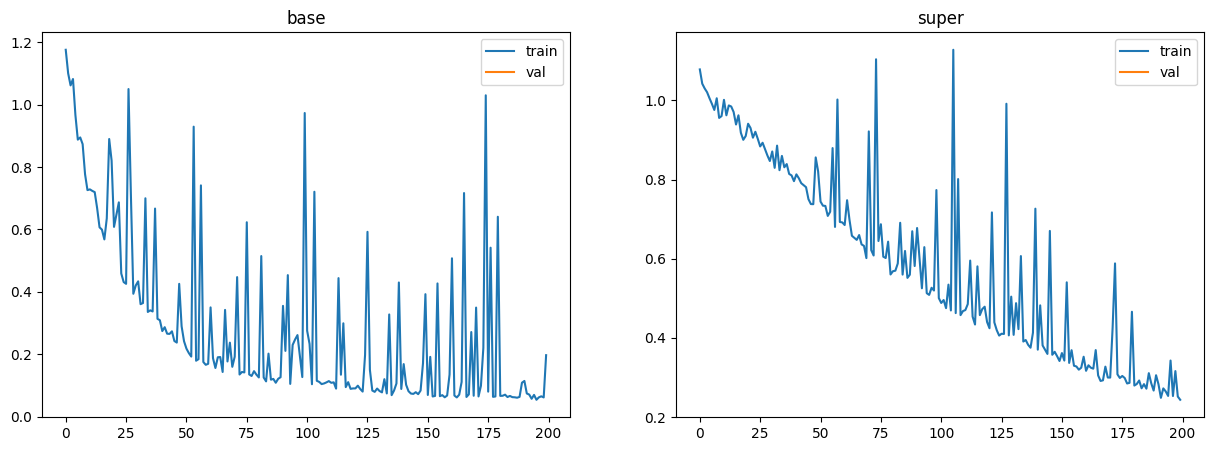

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i, unet_name in enumerate(['base', 'super']):
    ax[i].set_title(unet_name)
    ax[i].plot(train_unet_losses[unet_name], label='train')
    ax[i].plot(val_unet_losses[unet_name], label='val')
    ax[i].legend()

# inference

In [47]:
x=next(iter(train_dataloader))

sampling loop time step: 100%|██████████| 25/25 [00:00<00:00, 264.11it/s]
2it [00:00,  9.16it/s]


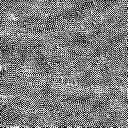

In [26]:
sample_args = {"cond_scale": 1.0}
texts = x["cond_image"][0]
# texts = x["cond_image"]
samples = imagen.sample(
    # texts=texts,
    text_embeds=x["encoding"][0].unsqueeze(0),
    text_masks=x["mask"][0].unsqueeze(0),
    return_pil_images=True,
    **sample_args
)
samples[0]

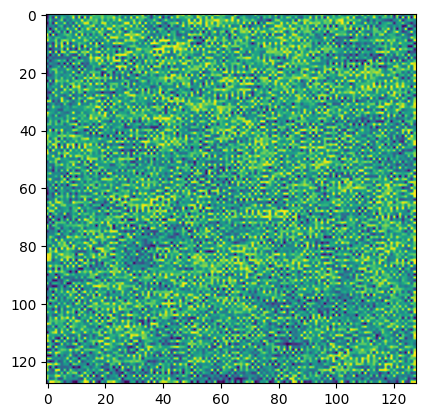

In [80]:
plt.imshow(samples[0,0].cpu())

In [ ]:
random_index = 1
plt.imshow(samples[-1][random_index].reshape(*input_img_size, input_channels), cmap="gray")